In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
import scipy.stats as sc
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap
import time

In [37]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

confidence_level = 0.95

In [39]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

reanalysis_color_dict = dict(zip(['ERA5', 'MERRA', 'JRA'], ['r','k','b']))

In [364]:
aht_6hrly = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

In [4]:
amip_ds = xr.open_dataset('../AHT_trends_work/amip_aht.nc')
hist_ds = xr.open_dataset('../AHT_trends_work/hist_aht.nc')
reanalysis_ds = xr.open_dataset('../AHT_trends_work/reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [5]:
amip_std_error = xr.open_dataset('../AHT_trends_work/amip_ds_trend_std_error.nc')
hist_std_error = xr.open_dataset('../AHT_trends_work/hist_ds_trend_std_error.nc')
reanalysis_std_error = xr.open_dataset('../AHT_trends_work/reanalysis_ds_trend_std_error.nc')
cesm_std_error = xr.open_dataset('../AHT_trends_work/cesm2_le_ds_trend_std_error.nc')
cesm_goga_std_error = xr.open_dataset('../AHT_trends_work/cesm2_amip_le_ds_trend_std_error.nc')
cesm_toga_std_error = xr.open_dataset('../AHT_trends_work/cesm2_toga_amip_le_ds_trend_std_error.nc')

In [6]:
amip_Neff = xr.open_dataset('../AHT_trends_work/amip_ds_trend_Neff.nc')
hist_Neff = xr.open_dataset('../AHT_trends_work/hist_ds_trend_Neff.nc')
reanalysis_Neff = xr.open_dataset('../AHT_trends_work/reanalysis_ds_trend_Neff.nc')
cesm_Neff = xr.open_dataset('../AHT_trends_work/cesm2_le_ds_trend_Neff.nc')
cesm_goga_Neff = xr.open_dataset('../AHT_trends_work/cesm2_amip_le_ds_trend_Neff.nc')
cesm_toga_Neff = xr.open_dataset('../AHT_trends_work/cesm2_toga_amip_le_ds_trend_Neff.nc')

In [7]:
#All CESM runs are offset by one month - need to fix this, also have the spike every 10 year issue with this data

cesm2_time = pd.date_range("1950-01-01","2014-12-31",freq='1M')
cesm2_le_ds_full = xr.open_dataset('../CESM_aht/CESM2_LENS2_aht_ds.nc')
cesm2_le_ds_full['time'] = cesm2_time
cesm2_le_ds = cesm2_le_ds_full.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_amip_time = pd.date_range("1949-12-31","2014-11-30",freq='1M')

cesm2_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_GOGA_AMIP_aht_ds.nc')
cesm2_amip_le_ds['time'] = cesm2_amip_time
cesm2_amip_le_ds = cesm2_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_toga_amip_le_ds = xr.open_dataset('../CESM_aht/CESM2_TOGA_AMIP_aht_ds.nc')
cesm2_toga_amip_le_ds['time'] = cesm2_amip_time
cesm2_toga_amip_le_ds = cesm2_toga_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_le_trends = cesm2_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_amip_le_trends = cesm2_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_toga_amip_le_trends = cesm2_toga_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [107]:
hist_pr = xr.open_dataset('../AHT_trends_work/hist_pr_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
amip_pr = xr.open_dataset('../AHT_trends_work/amip_pr_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_pr = xr.open_dataset('../AHT_trends_work/cesm2_lens2_pr.nc').sel(time=slice('1980-01-01','2014-12-31'))

hist_pr = hist_pr.sel(model=hist_ds.model)
amip_pr = amip_pr.sel(model=amip_ds.model)

hist_pr_trend = hist_pr.groupby('time.year').mean('time').polyfit(deg=1, dim='year').sel(degree=1)
amip_pr_trend = amip_pr.groupby('time.year').mean('time').polyfit(deg=1, dim='year').sel(degree=1)
cesm_pr_trend = cesm_pr.groupby('time.year').mean('time').polyfit(deg=1, dim='year').sel(degree=1)

In [117]:
reanalysis_pr = xr.open_dataset('../AHT_trends_work/reanalysis_precip.nc')

reanalysis_pr_trend = reanalysis_pr.groupby('time.year').mean('time').polyfit(deg=1, dim='year').sel(degree=1)


gpcp_precip = xr.open_dataset('../AHT_trends_work/gpcp_precip.nc').precip.sel(time=slice('1980-01-01','2014-12-31')).mean(['lon'])
gpcp_precip_trend = gpcp_precip.groupby('time.year').mean('time').polyfit(dim='year', deg=1)


In [123]:
amip_pr_std_error = xr.open_dataset('../AHT_trends_work/amip_pr_trend_std_error.nc')
amip_pr_Neff = xr.open_dataset('../AHT_trends_work/amip_pr_trend_Neff.nc')

hist_pr_std_error = xr.open_dataset('../AHT_trends_work/hist_pr_trend_std_error.nc')
hist_pr_Neff = xr.open_dataset('../AHT_trends_work/hist_pr_trend_Neff.nc')

reanalysis_pr_std_error = xr.open_dataset('../AHT_trends_work/reanalysis_pr_trend_std_error.nc')
reanalysis_pr_Neff = xr.open_dataset('../AHT_trends_work/reanalysis_pr_trend_Neff.nc')

cesm_pr_std_error = xr.open_dataset('../AHT_trends_work/cesm_pr_trend_std_error.nc')
cesm_pr_Neff = xr.open_dataset('../AHT_trends_work/cesm_pr_trend_Neff.nc')

hist_pr_std_error = hist_pr_std_error.sel(model=hist_ds.model)
hist_pr_Neff = hist_pr_Neff.sel(model=hist_ds.model)
amip_pr_std_error = amip_pr_std_error.sel(model=amip_ds.model)
amip_pr_Neff = amip_pr_Neff.sel(model=amip_ds.model)

In [8]:
def get_sig_vals_reanalysis(field_name):
    
    confidence_level = 0.95
    
    new_field_name = f"{field_name.split('_')[0]}_{field_name.split('_')[1]}"
    
    reanalysis_Neff_val = reanalysis_Neff[new_field_name].mean('model')
    
    #reanalysis_Neff_val_ave = np.sqrt((reanalysis_Neff_val ** 2).sum('model'))

    t_vals_reanalysis = sc.t.ppf((1 + confidence_level)/2, (reanalysis_Neff_val.values))
    
    #std_err_vals = np.sqrt(((40 / 1e15 * reanalysis_std_error[new_field_name]) ** 2).sum('model'))
    std_err_vals = (40 / 1e15 * reanalysis_std_error[new_field_name])

    t_values_reanalysis = ((40 / 1e15 * reanalysis_trends[field_name].sel(degree=1)) / std_err_vals).mean('model')

    #t_values_reanalysis_ave = np.sqrt((t_values_reanalysis ** 2).sum('model'))
    
    sig_reanalysis = xr.where(abs(t_values_reanalysis) > t_vals_reanalysis, True, False)

    return sig_reanalysis#, t_values_reanalysis, t_vals_reanalysis


In [35]:
def reanalysis_sig(field_vals, field_name, lat_slice):
    
    new_field_name = f"{field_name.split('_')[0]}_{field_name.split('_')[1]}"
    
    reanalysis_Neff_val = reanalysis_Neff[new_field_name].sel(latitude=lat_slice).mean('latitude')
    t_vals_reanalysis = sc.t.ppf((1 + confidence_level)/2, (reanalysis_Neff_val.values))
    t_values_reanalysis = field_vals / (40 / 1e15 * reanalysis_std_error[new_field_name].sel(latitude=lat_slice).mean('latitude'))
    sig_reanalysis = xr.where(abs(t_values_reanalysis) > t_vals_reanalysis, True, False)
    
    return sig_reanalysis

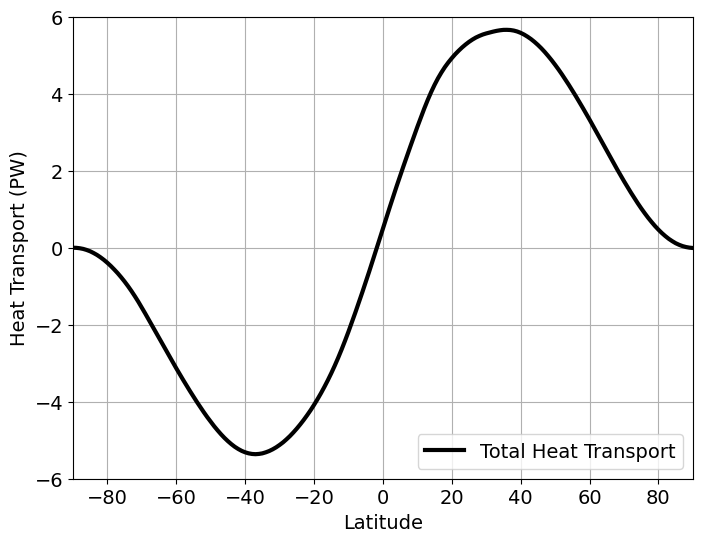

In [269]:
plt.figure(figsize=(8,6))
(hist_ds.total_mht.mean(['time', 'model']) / 1e15).plot(label='Total Heat Transport', lw=3, color='k')
#(hist_ds.total_aht.mean(['time', 'model']) / 1e15).plot(label='Atmospheric Heat Transport', lw=3, color='r')
#(hist_ds.total_oht.mean(['time', 'model']) / 1e15).plot(label='Oceanic Heat Transport', lw=3, color='b')

plt.grid()

plt.legend(loc=4, fontsize=14)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Heat Transport (PW)', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-6, 6])
plt.xlim([-90, 90])

#plt.savefig('total_mht_climatology')
plt.show()

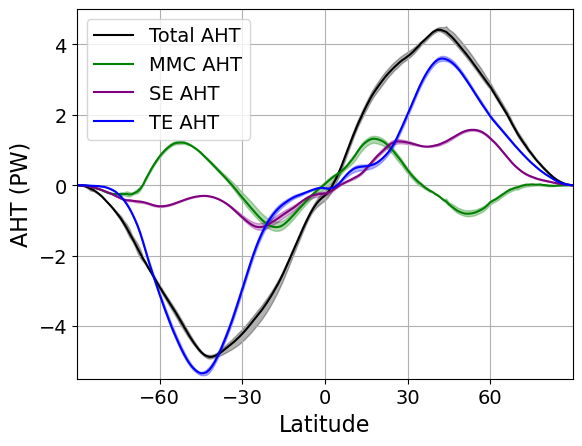

In [363]:
plt.plot(reanalysis_ds.latitude, reanalysis_ds.mean(['model', 'time']).total_aht / 1e15,
        label='Total AHT', color='k')
plt.fill_between(reanalysis_ds.latitude, reanalysis_ds.mean(['time']).total_aht.min('model') / 1e15,
        reanalysis_ds.mean(['time']).total_aht.max('model') / 1e15,  alpha=0.3, color='k')

plt.plot(reanalysis_ds.latitude, reanalysis_ds.mean(['model', 'time']).mmc_aht / 1e15,
        label='MMC AHT', color='g')
plt.fill_between(reanalysis_ds.latitude, reanalysis_ds.mean(['time']).mmc_aht.min('model') / 1e15,
        reanalysis_ds.mean(['time']).mmc_aht.max('model') / 1e15,  alpha=0.3, color='g')

plt.plot(reanalysis_ds.latitude, reanalysis_ds.mean(['model', 'time']).se_aht / 1e15,
        label='SE AHT', color='purple')
plt.fill_between(reanalysis_ds.latitude, reanalysis_ds.mean(['time']).se_aht.min('model') / 1e15,
        reanalysis_ds.mean(['time']).se_aht.max('model') / 1e15,  alpha=0.3, color='purple')

plt.plot(reanalysis_ds.latitude, reanalysis_ds.mean(['model', 'time']).te_aht / 1e15,
        label='TE AHT', color='b')
plt.fill_between(reanalysis_ds.latitude, reanalysis_ds.mean(['time']).te_aht.min('model') / 1e15,
        reanalysis_ds.mean(['time']).te_aht.max('model') / 1e15,  alpha=0.3, color='b')


plt.yticks([-4, -2, 0, 2, 4], fontsize=14)
plt.ylim([-5.5, 5])
plt.xticks([-60, -30, 0, 30, 60], fontsize=14)
plt.xlim([-90, 90])
plt.ylabel('AHT (PW)', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.grid()

#plt.savefig('reanalysis_mean_aht_total_mmc_se_te')
plt.show()

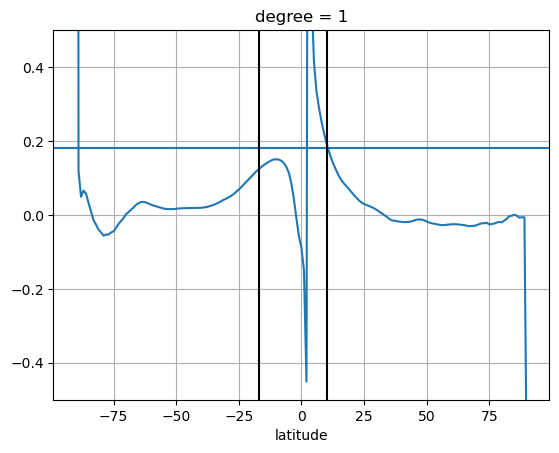

In [477]:
(40 * reanalysis_trends.total_aht_polyfit_coefficients.mean('model').sel(degree=1) / reanalysis_ds.total_aht.mean(['time', 'model'])).plot()

plt.ylim([-0.5, 0.5])

plt.axhline(0.18)
plt.axvline(10, color='k')
plt.axvline(-17, color='k')
plt.grid()
plt.show()



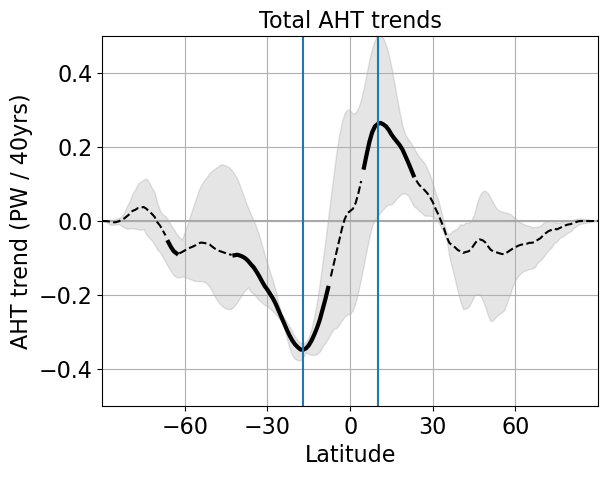

In [474]:
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70
aht_conv = 40 / 1e15

ylims = [-0.5, 0.5]
xlims = [-90, 90]

which_quantiles = [0.25, 0.75]
which_field = 'total_aht_polyfit_coefficients'

amip_total_aht = aht_conv * amip_trends[which_field].sel(degree=1).mean('model')
amip_total_aht_quantiles = aht_conv * amip_trends[which_field].sel(degree=1).quantile(which_quantiles, dim='model')
hist_total_aht = aht_conv * hist_trends[which_field].sel(degree=1).mean('model')
hist_total_aht_quantiles = aht_conv * hist_trends[which_field].sel(degree=1).quantile(which_quantiles, dim='model')
reanalysis_total_aht = aht_conv * reanalysis_trends[which_field].sel(degree=1)


reanalysis_sig_vals = get_sig_vals_reanalysis(which_field)

plt.axhline(0, color='darkgrey')

plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(reanalysis_sig_vals),
         '-', color=reanalysis_color, lw=3, label='Reanalysis')
plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(~reanalysis_sig_vals),
         '--', color=reanalysis_color, label='Reanalysis')

plt.fill_between(reanalysis_trends.latitude,  reanalysis_total_aht.min('model'),
                      reanalysis_total_aht.max('model'), color=reanalysis_color, alpha=0.1)

#plt.plot(amip_trends.latitude, amip_total_aht, color=amip_color, label='AMIP')
#plt.fill_between(amip_trends.latitude,  amip_total_aht_quantiles.isel(quantile=0),
                     # amip_total_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.1)
#plt.plot(hist_trends.latitude, hist_total_aht, color=hist_color, label='Coupled')
#plt.fill_between(hist_trends.latitude,  hist_total_aht_quantiles.isel(quantile=0),
                      #hist_total_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.1)

plt.ylim(ylims)
plt.xlim(xlims)
plt.xticks([-60, -30, 0, 30, 60], fontsize=16)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=16)
#plt.xticklabels('')

#plt.axvline(vline1)
#plt.axvline(vline2)
plt.ylabel('AHT trend (PW / 40yrs)', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.title('Total AHT trends', fontsize=16)


plt.grid()


#plt.savefig('total_aht_trends_reanalysis', bbox_inches='tight')
plt.show()


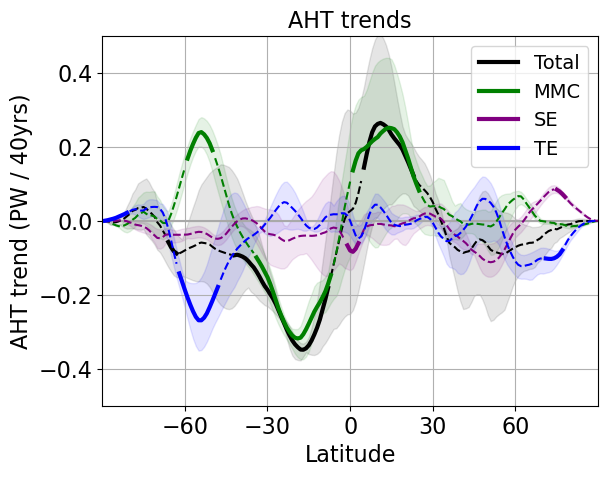

In [344]:
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70
aht_conv = 40 / 1e15

ylims = [-0.5, 0.5]
xlims = [-90, 90]

which_quantiles = [0.25, 0.75]


reanalysis_total_aht = aht_conv * reanalysis_trends['total_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_total_sig_vals = get_sig_vals_reanalysis('total_aht_polyfit_coefficients')

reanalysis_te_aht = aht_conv * reanalysis_trends['te_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_te_sig_vals = get_sig_vals_reanalysis('te_aht_polyfit_coefficients')

reanalysis_se_aht = aht_conv * reanalysis_trends['se_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_se_sig_vals = get_sig_vals_reanalysis('se_aht_polyfit_coefficients')

reanalysis_mmc_aht = aht_conv * reanalysis_trends['mmc_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_mmc_sig_vals = get_sig_vals_reanalysis('mmc_aht_polyfit_coefficients')

plt.axhline(0, color='darkgrey')

plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(reanalysis_total_sig_vals),
         '-', color='k', lw=3, label='Total')
plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(~reanalysis_total_sig_vals),
         '--', color='k')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_total_aht.min('model'),
                      reanalysis_total_aht.max('model'), color='k', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_mmc_aht.mean('model').where(reanalysis_mmc_sig_vals),
         '-', color='g', lw=3, label='MMC')
plt.plot(reanalysis_trends.latitude, reanalysis_mmc_aht.mean('model').where(~reanalysis_mmc_sig_vals),
         '--', color='g')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_mmc_aht.min('model'),
                      reanalysis_mmc_aht.max('model'), color='g', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model').where(reanalysis_se_sig_vals),
         '-', color='purple', lw=3, label='SE')
plt.plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model').where(~reanalysis_se_sig_vals),
         '--', color='purple')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_se_aht.min('model'),
                      reanalysis_se_aht.max('model'), color='purple', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_te_aht.mean('model').where(reanalysis_te_sig_vals),
         '-', color='b', lw=3, label='TE')
plt.plot(reanalysis_trends.latitude, reanalysis_te_aht.mean('model').where(~reanalysis_te_sig_vals),
         '--', color='b')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_te_aht.min('model'),
                      reanalysis_te_aht.max('model'), color='b', alpha=0.1)

#plt.plot(amip_trends.latitude, amip_total_aht, color=amip_color, label='AMIP')
#plt.fill_between(amip_trends.latitude,  amip_total_aht_quantiles.isel(quantile=0),
                     # amip_total_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.1)
#plt.plot(hist_trends.latitude, hist_total_aht, color=hist_color, label='Coupled')
#plt.fill_between(hist_trends.latitude,  hist_total_aht_quantiles.isel(quantile=0),
                      #hist_total_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.1)

plt.ylim(ylims)
plt.xlim(xlims)
plt.xticks([-60, -30, 0, 30, 60], fontsize=16)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=16)
#plt.xticklabels('')

#plt.axvline(vline1)
#plt.axvline(vline2)
plt.ylabel('AHT trend (PW / 40yrs)', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.title('AHT trends', fontsize=16)


plt.grid()
plt.legend(loc=1, fontsize=14)

#plt.savefig('total_mmc_te_se_aht_trends_reanalysis', bbox_inches='tight')
plt.show()


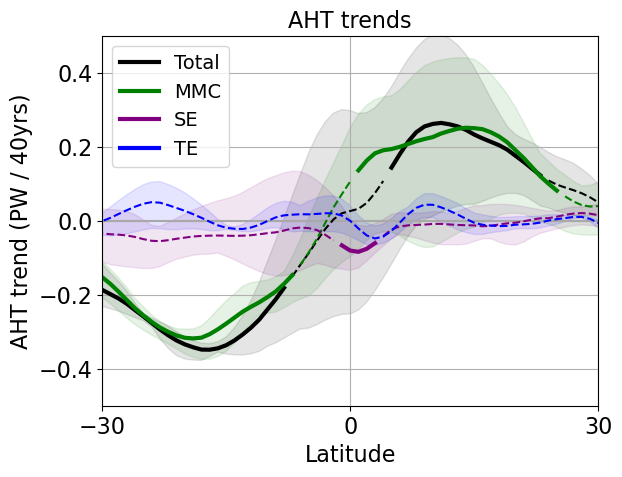

In [75]:
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70
aht_conv = 40 / 1e15

ylims = [-0.5, 0.5]
xlims = [-30, 30]

which_quantiles = [0.25, 0.75]


reanalysis_total_aht = aht_conv * reanalysis_trends['total_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_total_sig_vals = get_sig_vals_reanalysis('total_aht_polyfit_coefficients')

reanalysis_te_aht = aht_conv * reanalysis_trends['te_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_te_sig_vals = get_sig_vals_reanalysis('te_aht_polyfit_coefficients')

reanalysis_se_aht = aht_conv * reanalysis_trends['se_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_se_sig_vals = get_sig_vals_reanalysis('se_aht_polyfit_coefficients')

reanalysis_mmc_aht = aht_conv * reanalysis_trends['mmc_aht_polyfit_coefficients'].sel(degree=1)
reanalysis_mmc_sig_vals = get_sig_vals_reanalysis('mmc_aht_polyfit_coefficients')

plt.axhline(0, color='darkgrey')

plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(reanalysis_total_sig_vals),
         '-', color='k', lw=3, label='Total')
plt.plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model').where(~reanalysis_total_sig_vals),
         '--', color='k')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_total_aht.min('model'),
                      reanalysis_total_aht.max('model'), color='k', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_mmc_aht.mean('model').where(reanalysis_mmc_sig_vals),
         '-', color='g', lw=3, label='MMC')
plt.plot(reanalysis_trends.latitude, reanalysis_mmc_aht.mean('model').where(~reanalysis_mmc_sig_vals),
         '--', color='g')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_mmc_aht.min('model'),
                      reanalysis_mmc_aht.max('model'), color='g', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model').where(reanalysis_se_sig_vals),
         '-', color='purple', lw=3, label='SE')
plt.plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model').where(~reanalysis_se_sig_vals),
         '--', color='purple')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_se_aht.min('model'),
                      reanalysis_se_aht.max('model'), color='purple', alpha=0.1)

plt.plot(reanalysis_trends.latitude, reanalysis_te_aht.mean('model').where(reanalysis_te_sig_vals),
         '-', color='b', lw=3, label='TE')
plt.plot(reanalysis_trends.latitude, reanalysis_te_aht.mean('model').where(~reanalysis_te_sig_vals),
         '--', color='b')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_te_aht.min('model'),
                      reanalysis_te_aht.max('model'), color='b', alpha=0.1)

#plt.plot(amip_trends.latitude, amip_total_aht, color=amip_color, label='AMIP')
#plt.fill_between(amip_trends.latitude,  amip_total_aht_quantiles.isel(quantile=0),
                     # amip_total_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.1)
#plt.plot(hist_trends.latitude, hist_total_aht, color=hist_color, label='Coupled')
#plt.fill_between(hist_trends.latitude,  hist_total_aht_quantiles.isel(quantile=0),
                      #hist_total_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.1)

plt.ylim(ylims)
plt.xlim(xlims)
plt.xticks([-30, 0, 30], fontsize=16)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], fontsize=16)
#plt.xticklabels('')

#plt.axvline(vline1)
#plt.axvline(vline2)
plt.ylabel('AHT trend (PW / 40yrs)', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.title('AHT trends', fontsize=16)


plt.grid()
plt.legend(loc=2, fontsize=14)

#plt.savefig('total_mmc_se_te_aht_trends_reanalysis_tropics', bbox_inches='tight')
plt.show()


In [33]:
def violin_plot(data, ax):
    
    

    parts = ax.violinplot(data, showmedians=False, showmeans=False, showextrema=False,
                    widths=violin_width)

    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(0.9)
        
    

    quartile11, median1, quartile13 = np.percentile(data[0], [25, 50, 75])
    quartile21, median2, quartile23 = np.percentile(data[1], [25, 50, 75])
    
    mean1 = np.mean(data[0])
    mean2 = np.mean(data[1])

    inds = [1, 2]
    #ax.scatter(inds, [median1, median2], marker='o', color='white', s=30, zorder=3)
    ax.scatter(inds, [mean1, mean2], marker='o', color='white', s=30, zorder=3)
    ax.vlines(1, quartile11, quartile13, color='k', linestyle='-', lw=5)
    ax.vlines(2, quartile21, quartile23, color='k', linestyle='-', lw=5)
    #ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

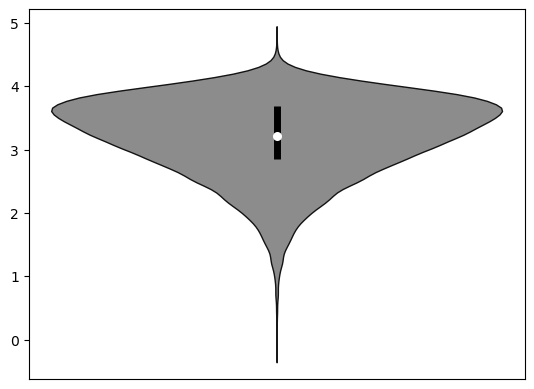

In [68]:
def skew_norm_pdf(x,e=0,w=1,a=0):
    # adapated from:
    # http://stackoverflow.com/questions/5884768/skew-normal-distribution-in-scipy
    t = (x-e) / w
    return 2.0 * w * sc.norm.pdf(t) * sc.norm.cdf(a*t)

def randn_skew_fast(N, alpha=0.0, loc=0.0, scale=1.0):
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1

# generate the skew normal PDF for reference:
location = 4
scale = 1.0
x = np.linspace(-5,5,100) 

#p = skew_norm_pdf(x,location,scale,-3)

p = randn_skew_fast(50000, -5, 4, 1)


parts = plt.violinplot(p, showmedians=False, showmeans=False, showextrema=False,
                widths=violin_width)

for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)



quartile11, median1, quartile13 = np.percentile(p, [25, 50, 75])

mean1 = np.mean(p)

inds = [1]
#ax.scatter(inds, [median1, median2], marker='o', color='white', s=30, zorder=3)
plt.scatter(inds, [mean1], marker='o', color='white', s=30, zorder=3)
plt.vlines(1, quartile11, quartile13, color='k', linestyle='-', lw=5)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

#plt.savefig('sample_violin_plot')
plt.show()

<ipython-input-95-a8c571a72695>:49: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-95-a8c571a72695>:49: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-95-a8c571a72695>:111: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['C'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-95-a8c571a72695>:140: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated sinc

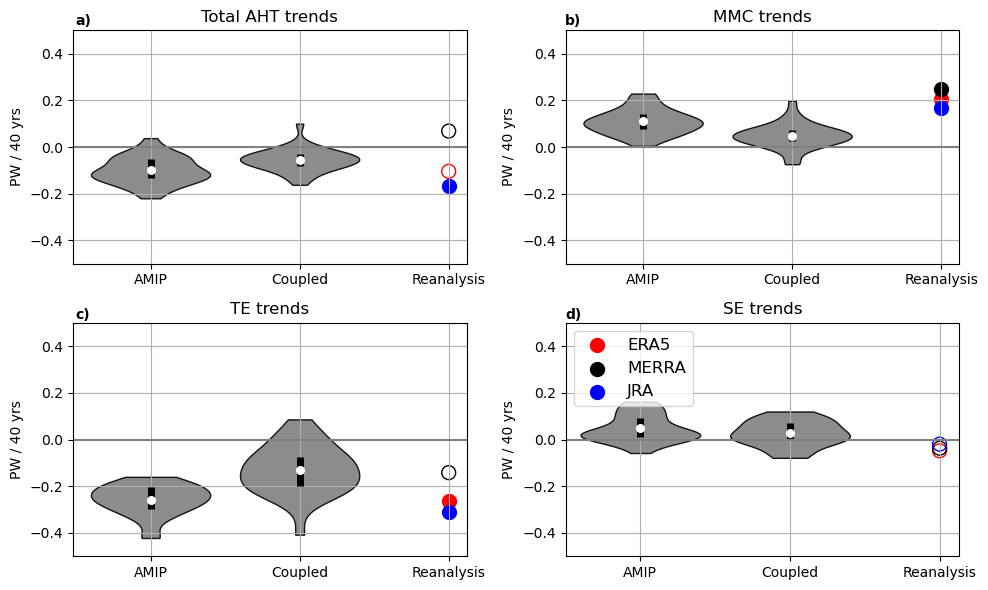

In [95]:
field1 = 'total_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'te_aht_polyfit_coefficients'
field5 = 'se_aht_polyfit_coefficients'
#which_lat = -60
lat_slice = slice(-60, -50)
#lat_slice = slice(49, 51)
ylim = [-0.5, 0.5]
violin_width = 0.8
box_width = 0.6
violin_color = 'grey'

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B'], ['C', 'D']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('Total AHT trends')
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)

violin_plot([amip_data, hist_data], axs['A'])  
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field1, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC trends')
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])    

#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field2, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')


amip_data = amip_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['C'].set_title('TE trends') 
axs['C'].axhline(0, color='grey')
#axs['C'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['C'])  
#axs['C'].boxplot([amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3])
axs['C'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['C'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field4, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['C'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['C'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['C'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['D'].set_title('SE trends')
axs['D'].axhline(0, color='grey')
#axs['D'].violinplot([amip_data, hist_data], showmedians=True, showmeans=False, showextrema=False,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['D'])  
    
#axs['D'].boxplot([amip_data, hist_data], widths=box_width)
#axs['D'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field5, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['D'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['D'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#scatter = axs['D'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['D'].set_xticks([1, 2, 3])
axs['D'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
axs['D'].grid()
axs['D'].set_ylim(ylim)
axs['D'].set_ylabel('PW / 40 yrs')


plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)

#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

fig.text(0.08, 0.95, 'a)', fontweight='semibold')
fig.text(0.57, 0.95, 'b)', fontweight='semibold')
fig.text(0.08, 0.46, 'c)', fontweight='semibold')
fig.text(0.57, 0.46, 'd)', fontweight='semibold')
#plt.savefig('s_ocean_aht_trends_boxplot')
plt.show()

<ipython-input-106-fe99e2ef5fda>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),


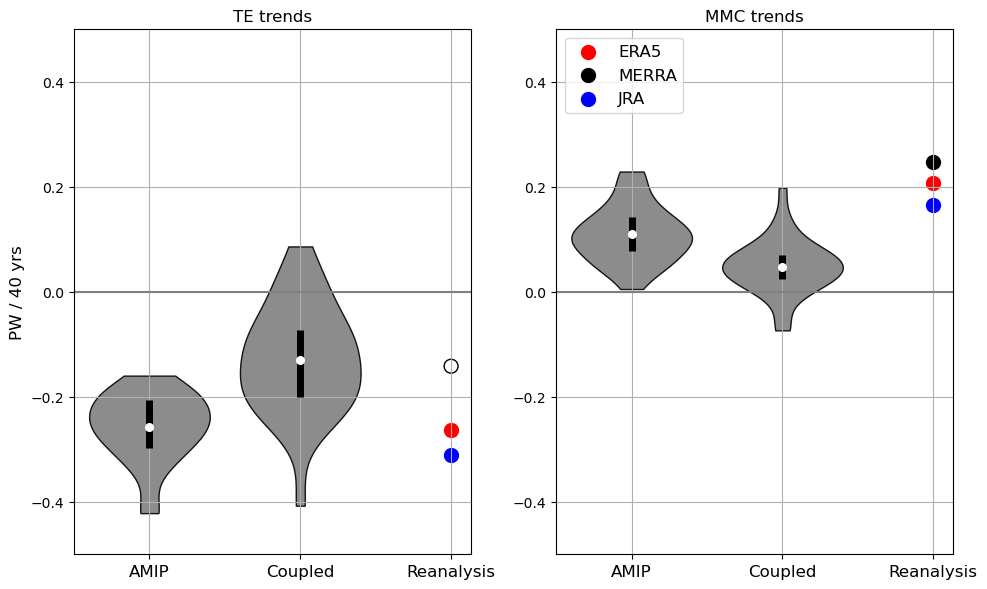

In [106]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
lat_slice1 = slice(-60, -50)
ylim = [-0.5, 0.5]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('TE trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
axs['A'].set_xlim([0.5, 3.13])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC trends') 
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])
#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
#axs['B'].set_ylabel('PW / 40 yrs')

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice2)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)

#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)


plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

#fig.text(0.08, 0.95, 'a)', fontweight='semibold')
#fig.text(0.57, 0.95, 'b)', fontweight='semibold')

#plt.savefig('s_ocean_te_mmc_violin_reanalysis')
plt.show()

<ipython-input-125-577d83bd1913>:73: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['B'].scatter(3, reanalysis_data.sel(model=model),


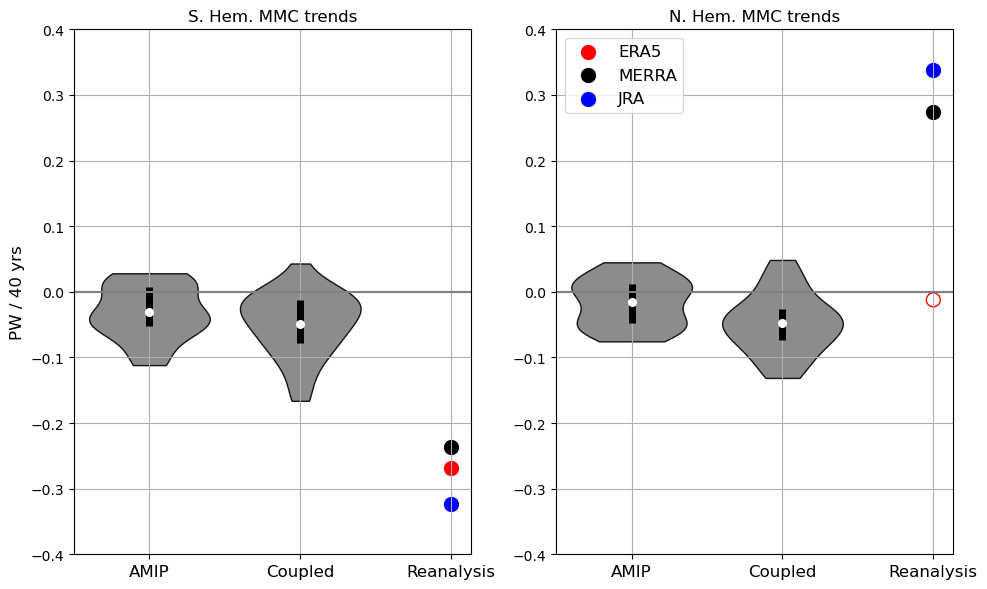

In [125]:
field = 'mmc_aht_polyfit_coefficients'
lat_slice1 = slice(-25, -10)
lat_slice2 = slice(10, 25)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('S. Hem. MMC trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
axs['A'].set_xlim([0.5, 3.13])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

amip_data = amip_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('N. Hem. MMC trends') 
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])
#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
#axs['B'].set_ylabel('PW / 40 yrs')

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice2)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)

#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)


plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

#fig.text(0.08, 0.95, 'a)', fontweight='semibold')
#fig.text(0.57, 0.95, 'b)', fontweight='semibold')

#plt.savefig('tropics_mmc_violin_reanalysis_models')
plt.show()

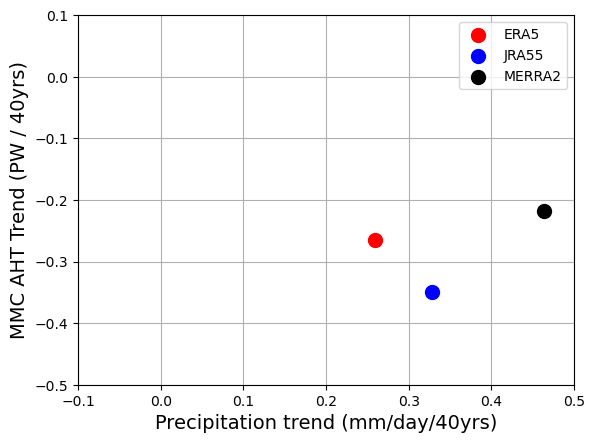

In [231]:
pr_slice = slice(-10, 30)
aht_slice = slice(-16, -14)

pr_slice_reanalysis = slice(30, -10)

model_adjust = 86400
cesm_adjust = 86400 * 1000
aht_adjust = 40 / 1e15
pr_adjust = 40


prs_data = []

prs_data.append((pr_adjust * hist_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust).values)
prs_data.append((pr_adjust * amip_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust).values)
prs_data.append((pr_adjust * reanalysis_pr_trend.tp_polyfit_coefficients.sel(latitude=pr_slice_reanalysis).mean('latitude')).values)
prs_data.append((pr_adjust * cesm_adjust * cesm_pr_trend.PRECT_polyfit_coefficients.sel(lat=pr_slice).mean('lat')).values)

prs_data = np.hstack(prs_data)

aht_data = []

aht_data.append((aht_adjust * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')).values)
aht_data.append((aht_adjust * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')).values)
aht_data.append((aht_adjust * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')).values)
aht_data.append((aht_adjust * cesm2_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')).values)

aht_data = np.hstack(aht_data)

linregress_pr_aht = linregress(prs_data, aht_data)
slope = linregress_pr_aht.slope
int_val = linregress_pr_aht.intercept
r_val = linregress_pr_aht.rvalue
p_val = linregress_pr_aht.pvalue


#plt.plot(np.linspace(-0.1, 0.55, 50), int_val + np.linspace(-0.1, 0.55, 50) * slope, '--', color='k',
        #label='Linear best-fit')

hist_pr_val = pr_adjust * hist_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust
hist_aht_val = aht_adjust * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')

hist_Neff_val1 = hist_pr_Neff.pr.sel(latitude=pr_slice).mean('latitude')
hist_Neff_val2 = hist_Neff.mmc_aht.sel(latitude=aht_slice).mean('latitude')
t_vals_hist1 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val1.values)
t_vals_hist2 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val2.values)
t_values1_hist = hist_pr_val / (pr_adjust * model_adjust * hist_pr_std_error.pr.sel(latitude=pr_slice).mean('latitude'))
t_values2_hist = hist_aht_val / (aht_adjust * hist_std_error.mmc_aht.sel(latitude=aht_slice).mean('latitude'))
val1_sig_hist = xr.where(abs(t_values1_hist) > t_vals_hist1, True, False)
val2_sig_hist = xr.where(abs(t_values2_hist) > t_vals_hist2, True, False)

both_sig_hist = np.logical_and(val1_sig_hist, val2_sig_hist)

#plt.scatter(hist_pr_val.where(both_sig_hist), hist_aht_val.where(both_sig_hist), color='purple')
#plt.scatter(hist_pr_val.where(~both_sig_hist), hist_aht_val.where(~both_sig_hist), edgecolor='purple', facecolor='', label='Coupled')

#plt.scatter(pr_adjust * hist_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust,
          #aht_adjust * hist_aht_trend.mmc_aht_polyfit_coefficients.sel(latitude=aht_slice).mean('latitude'), 
           #facecolors='none', edgecolor='purple', label='Coupled')

amip_pr_val = pr_adjust * amip_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust
amip_aht_val = aht_adjust * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')

amip_Neff_val1 = amip_pr_Neff.pr.sel(latitude=pr_slice).mean('latitude')
amip_Neff_val2 = amip_Neff.mmc_aht.sel(latitude=aht_slice).mean('latitude')
t_vals_amip1 = sc.t.ppf((1 + confidence_level)/2, amip_Neff_val1.values)
t_vals_amip2 = sc.t.ppf((1 + confidence_level)/2, amip_Neff_val2.values)
t_values1_amip = amip_pr_val / (pr_adjust * model_adjust * amip_pr_std_error.pr.sel(latitude=pr_slice).mean('latitude'))
t_values2_amip = amip_aht_val / (aht_adjust * amip_std_error.mmc_aht.sel(latitude=aht_slice).mean('latitude'))
val1_sig_amip = xr.where(abs(t_values1_amip) > t_vals_amip1, True, False)
val2_sig_amip = xr.where(abs(t_values2_amip) > t_vals_amip2, True, False)

both_sig_amip = np.logical_and(val1_sig_amip, val2_sig_amip)

#plt.scatter(amip_pr_val.where(both_sig_amip), amip_aht_val.where(both_sig_amip), color='g')
#plt.scatter(amip_pr_val.where(~both_sig_amip), amip_aht_val.where(~both_sig_amip), edgecolor='g', facecolor='', label='AMIP')

#plt.scatter(pr_adjust * amip_pr_trend.pr_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * model_adjust,
          #aht_adjust * amip_aht_trend.mmc_aht_polyfit_coefficients.sel(latitude=aht_slice).mean('latitude'), 
           #facecolors='none', edgecolor='g', label='AMIP')

cesm_pr_val = pr_adjust * cesm_pr_trend.PRECT_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * cesm_adjust
cesm_aht_val = aht_adjust * cesm2_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')

cesm_Neff_val1 = cesm_pr_Neff.PRECT.sel(latitude=pr_slice).mean('latitude')
cesm_Neff_val2 = cesm_Neff.mmc_aht.sel(latitude=aht_slice).mean('latitude')
t_vals_cesm1 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val1.values)
t_vals_cesm2 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val2.values)
t_values1_cesm = cesm_pr_val / (pr_adjust * cesm_adjust * cesm_pr_std_error.PRECT.sel(latitude=pr_slice).mean('latitude'))
t_values2_cesm = cesm_aht_val / (aht_adjust * cesm_std_error.mmc_aht.sel(latitude=aht_slice).mean('latitude'))
val1_sig_cesm = xr.where(abs(t_values1_cesm) > t_vals_cesm1, True, False)
val2_sig_cesm = xr.where(abs(t_values2_cesm) > t_vals_cesm2, True, False)

both_sig_cesm = np.logical_and(val1_sig_cesm, val2_sig_cesm)

#plt.scatter(cesm_pr_val.where(both_sig_cesm), cesm_aht_val.where(both_sig_cesm), color='grey')
#plt.scatter(cesm_pr_val.where(~both_sig_cesm), cesm_aht_val.where(~both_sig_cesm), edgecolor='grey', facecolor='', label='CESM2')

#plt.scatter(pr_adjust * cesm_pr_trend.PRECT_polyfit_coefficients.sel(lat=pr_slice).mean('lat') * cesm_adjust,
          #aht_adjust * cesm_aht_trend.mmc_aht_polyfit_coefficients.sel(latitude=aht_slice).mean('latitude'), 
           #facecolors='none', edgecolor='grey', label='CESM2')

reanalysis_pr_val = pr_adjust * reanalysis_pr_trend.tp_polyfit_coefficients.sel(latitude=pr_slice_reanalysis).mean('latitude')
reanalysis_aht_val = aht_adjust * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).sel(latitude=aht_slice).mean('latitude')

reanalysis_Neff_val1 = reanalysis_pr_Neff.tp.sel(latitude=pr_slice_reanalysis).mean('latitude')
reanalysis_Neff_val2 = reanalysis_Neff.mmc_aht.sel(latitude=aht_slice).mean('latitude')
t_vals_reanalysis1 = sc.t.ppf((1 + confidence_level)/2, reanalysis_Neff_val1.values)
t_vals_reanalysis2 = sc.t.ppf((1 + confidence_level)/2, reanalysis_Neff_val2.values)
t_values1_reanalysis = reanalysis_pr_val / (pr_adjust * reanalysis_pr_std_error.tp.sel(latitude=pr_slice_reanalysis).mean('latitude'))
t_values2_reanalysis = reanalysis_aht_val / (aht_adjust * reanalysis_std_error.mmc_aht.sel(latitude=aht_slice).mean('latitude'))
val1_sig_reanalysis = xr.where(abs(t_values1_reanalysis) > t_vals_reanalysis1, True, False)
val2_sig_reanalysis = xr.where(abs(t_values2_reanalysis) > t_vals_reanalysis2, True, False)

both_sig_reanalysis = np.logical_and(val1_sig_reanalysis, val2_sig_reanalysis)

#plt.scatter(reanalysis_pr_val.sel(model='ERA5'),
           #reanalysis_aht_val.sel(model='ERA5'),
           #edgecolor='r', facecolor='', s=100,  label='ERA5')

#plt.scatter(reanalysis_pr_val.sel(model='JRA'),
           #reanalysis_aht_val.sel(model='JRA'),
           #edgecolor='b', facecolor='', s=100,  label='JRA55')

#plt.scatter(reanalysis_pr_val.sel(model='MERRA'),
           #reanalysis_aht_val.sel(model='MERRA'),
           #edgecolor='k', facecolor='', s=100,  label='MERRA2')

plt.scatter(reanalysis_pr_val.sel(model='ERA5'),
           reanalysis_aht_val.sel(model='ERA5'),
           color='r', s=100,  label='ERA5')

plt.scatter(reanalysis_pr_val.sel(model='JRA'),
           reanalysis_aht_val.sel(model='JRA'),
           color='b',  s=100,  label='JRA55')

plt.scatter(reanalysis_pr_val.sel(model='MERRA'),
           reanalysis_aht_val.sel(model='MERRA'),
           color='k', s=100,  label='MERRA2')

#plt.scatter(pr_adjust * reanalysis_pr_trend.tp_polyfit_coefficients.sel(latitude=pr_slice_reanalysis).mean('latitude').sel(model='JRA'),
           #aht_adjust * reanalysis_aht_trend.mmc_aht_polyfit_coefficients.sel(latitude=aht_slice).mean('latitude').sel(model='JRA'),
           #color='b', label='JRA55')

#plt.scatter(pr_adjust * reanalysis_pr_trend.tp_polyfit_coefficients.sel(latitude=pr_slice_reanalysis).mean('latitude').sel(model='MERRA'),
           #aht_adjust * reanalysis_aht_trend.mmc_aht_polyfit_coefficients.sel(latitude=aht_slice).mean('latitude').sel(model='MERRA'),
           #color='k', label='MERRA2')

#plt.axvline(pr_adjust * gpcp_precip_trend.polyfit_coefficients.sel(degree=1).sel(lat=pr_slice).mean('lat'),
           #color='k', lw=5, alpha=0.6)

plt.legend(loc=0)

plt.xlabel('Precipitation trend (mm/day/40yrs)', fontsize=14)
plt.ylabel('MMC AHT Trend (PW / 40yrs)', fontsize=14)
plt.grid()

plt.xlim([-0.1, 0.5])
plt.ylim([-0.5, 0.1])
#plt.savefig('precip_mmc_aht_scatter_reanalysis_')
plt.show()

In [223]:
print(reanalysis_Neff_val1.values)
print(reanalysis_pr_std_error.tp.sel(latitude=pr_slice_reanalysis).mean('latitude').values)
print(reanalysis_pr_val.values)
print(t_values1_reanalysis.values)
print(t_vals_reanalysis1)

[25.72621239 29.03326929 24.82386232]
[0.00481923 0.00523121 0.00603786]
[0.25977516 0.32762703 0.46409622]
[1.34759676 1.56573141 1.92160745]
[2.05659465 2.04512785 2.06027979]


In [232]:
amip_sst = xr.open_dataset('../AHT_trends_work/amip_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))
hist_sst = xr.open_dataset('../AHT_trends_work/hist_sst_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
obs_sst = xr.open_dataset('../AHT_trends_work/ersstv5.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_sst = xr.open_dataset('../AHT_trends_work/cesm2_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))

common_models = np.intersect1d(hist_sst.model.values, hist_ds.model.values)

hist_ds = hist_ds.sel(model=common_models)
hist_sst = hist_sst.sel(model=common_models)


hist_sst_std_error = xr.open_dataset('../hist_sst_trend_std_error.nc')
cesm_sst_std_error = xr.open_dataset('../cesm_sst_trend_std_error.nc')
hist_sst_Neff = xr.open_dataset('../hist_sst_trend_Neff.nc')
cesm_sst_Neff = xr.open_dataset('../cesm_sst_trend_Neff.nc')

hist_std_error = hist_std_error.sel(model=common_models)
hist_Neff = hist_Neff.sel(model=common_models)

hist_sst_std_error = hist_sst_std_error.sel(model=common_models)
hist_sst_Neff = hist_sst_Neff.sel(model=common_models)

In [348]:
num_reanal = 3
lat_reanal = 180
lon_reanal = 360
lev_reanal = 30
time_reanal = 4 * 365 * 45
vars_reanal = 4.2
bytes_reanal = 64

total_bytes_reanal = (num_reanal * lat_reanal * lon_reanal * lev_reanal * time_reanal * vars_reanal * bytes_reanal)

total_tb_reanal = total_bytes_reanal / 1024 / 1024 / 1024 / 1024

num_model = 180
lat_model = 90
lon_model = 180
lev_model = 18
time_model = 12 * 45
vars_model = 4.2
bytes_model = 64

total_bytes_model = (num_model * lat_model * lon_model * lev_model * time_model * vars_model * bytes_model)

total_tb_model = total_bytes_model / 1024 / 1024 / 1024 / 1024

print(f'Total TB for reanalysis is: {round(total_tb_reanal, 1)}')
print(f'Total TB for models is: {round(total_tb_model, 1)}')

Total TB for reanalysis is: 93.7
Total TB for models is: 6.9


In [318]:
sw_ds = xr.open_dataset('SW_data.nc')
sw_toa_ds = xr.open_dataset('SW_toa.nc')
sw_toa_net_ds = xr.open_dataset('TOA_net_SW.nc')
lw_toa_ds = xr.open_dataset('TOA_lw.nc')
ts_ds = xr.open_dataset('surf_temps.nc')

In [393]:
sw_toa_net_ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-12-01
Data variables:
    tsr        (time, latitude, longitude) float32 0.0 0.0 ... 1.356e+07
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-22 21:14:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

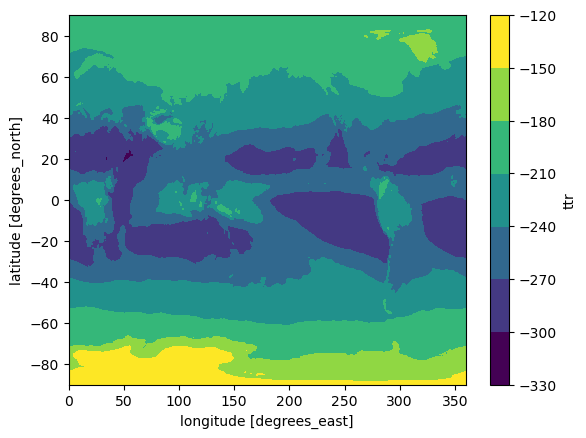

In [302]:
#(sw_ds.ssr.mean('time') / 24 / 60/ 60).plot.contourf()
(lw_toa_ds.ttr.mean('time') / 24 / 60/ 60).plot.contourf()

plt.show()

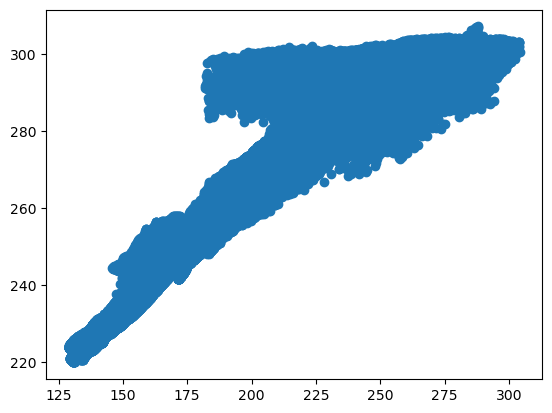

In [335]:


lw_sigma_t = ((-lw_toa_ds.ttr.mean('time') / 24 / 3600) / sigma) ** (0.25)
lw_initial = (-lw_toa_ds.ttr.mean('time') / 24 / 3600)
#initial_ratio = ts_ds.t2m.mean('time') / (lw_sigma_t)
initial_ratio = ts_ds.t2m.mean('time') / (lw_initial)
initial_diff = ts_ds.t2m.mean('time') - lw_sigma_t
#plt.scatter(-lw_toa_ds.ttr.mean('time') / 24 / 3600, ts_ds.t2m.mean('time'))
plt.scatter(lw_initial, ts_ds.t2m.mean('time'))

plt.show()

In [316]:
#c_to_f(ts_ds.t2m.mean('time').sel(latitude=47.6, longitude=237.7, method='nearest').values - 273)

(-lw_toa_ds.ttr.mean('time') / 24 / 3600).sel(latitude=47.6, longitude=237.7, method='nearest')


<xarray.DataArray 'ttr' ()>
array(229.2936, dtype=float32)
Coordinates:
    longitude  float32 237.8
    latitude   float32 47.5

In [317]:
seattle_data

<xarray.DataArray 'tisr' ()>
array(295.49564, dtype=float32)
Coordinates:
    longitude  float32 237.8
    latitude   float32 47.5

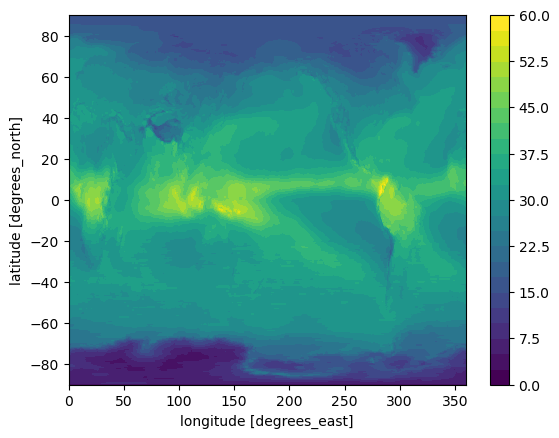

In [336]:
initial_diff.plot.contourf(levels=30)

plt.show()

In [342]:

seattle_clima = ts_ds.t2m.mean('time').sel(latitude=47.6, longitude=237.7, method='nearest')
miami_clima = ts_ds.t2m.mean('time').sel(latitude=25.8, longitude=279.8, method='nearest')
anchorage_clima = ts_ds.t2m.mean('time').sel(latitude=61.2, longitude=210.1, method='nearest')

def c_to_f(c_val):
    return round(c_val * (9/5) + 32, 1)

print(f'Seattle temp is {c_to_f(seattle_clima.values - 273)}')
print(f'Miami temp is {c_to_f(miami_clima.values - 273)}')
print(f'Anchorage temp is {c_to_f(anchorage_clima.values - 273)}')


Seattle temp is 52.4
Miami temp is 75.7
Anchorage temp is 36.7


In [341]:
#seattle_data = (sw_ds.ssrd.mean('time') / 24 / 60/ 60).sel(latitude=47.6, longitude=237.7, method='nearest')
seattle_data = (sw_toa_net_ds.tsr.mean('time') / 24 / 60/ 60).sel(latitude=47.6, longitude=237.7, method='nearest')
miami_data = (sw_toa_net_ds.tsr.mean('time') / 24 / 60/ 60).sel(latitude=25.8, longitude=279.8, method='nearest')
anchorage_data = (sw_toa_net_ds.tsr.mean('time') / 24 / 60/ 60).sel(latitude=61.2, longitude=210.1, method='nearest')

sigma = 5.67e-8

seattle_temp = (seattle_data / sigma) ** (0.25) + initial_diff.sel(latitude=47.6, longitude=237.7, method='nearest')
miami_temp = (miami_data / sigma) ** (0.25) + initial_diff.sel(latitude=25.8, longitude=279.8, method='nearest')
anchorage_temp = (anchorage_data / sigma) ** (0.25) + initial_diff.sel(latitude=61.2, longitude=210.1, method='nearest')

print(f'Seattle temp is {c_to_f(seattle_temp.values - 273)}')
print(f'Miami temp is {c_to_f(miami_temp.values - 273)}')
print(f'Anchorage temp is {c_to_f(anchorage_temp.values - 273)}')


Seattle temp is 38.0
Miami temp is 85.5
Anchorage temp is -3.5


In [345]:
test = xr.open_dataset('../aht_calcs/1985/1985_00z_0_9')

In [346]:
test

<xarray.Dataset>
Dimensions:         (time: 10, level: 37, latitude: 361, longitude: 720)
Coordinates:
  * time            (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-01-10
  * latitude        (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude       (longitude) float64 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * level           (level) int64 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
Data variables:
    mmc_tot_int     (time, level, latitude) float64 ...
    mmc_dry_int     (time, level, latitude) float64 ...
    mmc_moist_int   (time, level, latitude) float64 ...
    eddy_tot_int    (time, level, latitude, longitude) float64 ...
    eddy_dry_int    (time, level, latitude, longitude) float64 ...
    eddy_moist_int  (time, level, latitude, longitude) float64 ...

In [352]:
(160000 * 1e12 / (365 * 24)) / 1e15

0.0182648401826484

In [460]:
(617 * 1e18) / (365 * 24 * 60 * 60) / 1e15

0.01956494165398275

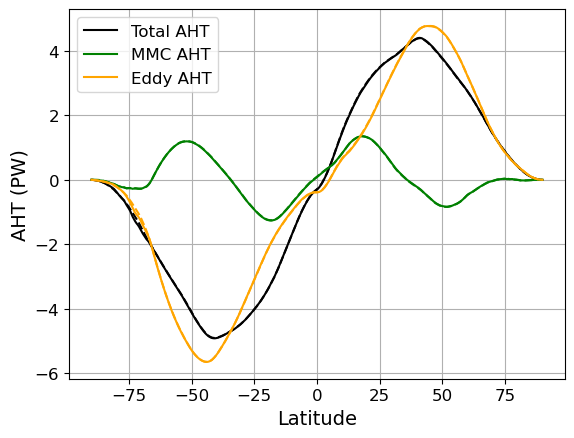

In [383]:
time_slice = slice('1980-01-01', '2014-12-31')

(aht_6hrly.total_aht.sel(time=time_slice).mean('time') / 1e15).plot(color='k', label='Total AHT')
(reanalysis_ds.total_aht.sel(model='ERA5').sel(time=time_slice).mean('time') / 1e15).plot(linestyle='--', color='k')

(aht_6hrly.mmc_aht.sel(time=time_slice).mean('time') / 1e15).plot(color='g', label='MMC AHT')
(reanalysis_ds.mmc_aht.sel(model='ERA5').sel(time=time_slice).mean('time') / 1e15).plot(linestyle='--', color='g')

(aht_6hrly.eddy_aht.sel(time=time_slice).mean('time') / 1e15).plot(color='orange', label='Eddy AHT')
(reanalysis_ds.eddy_aht.sel(model='ERA5').sel(time=time_slice).mean('time') / 1e15).plot(linestyle='--', color='orange')


plt.grid()

plt.legend(loc=0, fontsize=12)

plt.title('')

plt.xlabel('Latitude', fontsize=14)
plt.ylabel('AHT (PW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('6hrly_time_mean_aht_w_monthly')
plt.show()

In [432]:
rad_mask = xr.where(-lw_toa_ds.ttr.mean(['time', 'longitude']) > sw_toa_net_ds.tsr.mean(['time', 'longitude']), True, False)

rad_mask[504:520]

#36.25
rad_slice1 = slice(36.25, -36.25)
rad_slice2 = slice(90, 36.25)
rad_slice3 = slice(-36.25, -90)


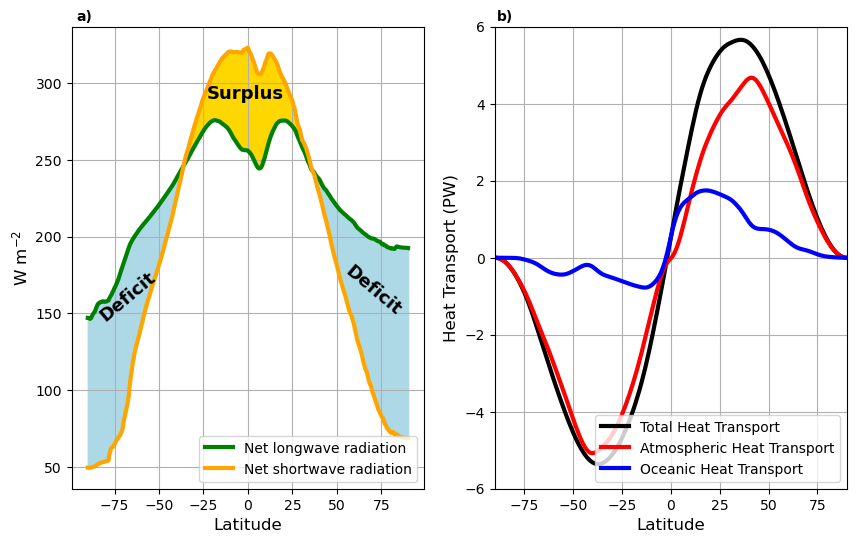

In [479]:
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

(-lw_toa_ds.ttr.mean('time') / 24 / 3600).mean('longitude').plot(ax=axs['A'], lw=3, color='g', label='Net longwave radiation')
(sw_toa_net_ds.tsr.mean('time') / 24 / 3600).mean('longitude').plot(ax=axs['A'], lw=3, color='orange', label='Net shortwave radiation')

axs['A'].fill_between(sw_toa_net_ds.latitude.sel(latitude=rad_slice1),
                      (-lw_toa_ds.ttr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice1),
                      (sw_toa_net_ds.tsr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice1), color='gold')

axs['A'].fill_between(sw_toa_net_ds.latitude.sel(latitude=rad_slice2),
                      (-lw_toa_ds.ttr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice2),
                      (sw_toa_net_ds.tsr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice2), color='lightblue')

axs['A'].fill_between(sw_toa_net_ds.latitude.sel(latitude=rad_slice3),
                      (-lw_toa_ds.ttr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice3),
                      (sw_toa_net_ds.tsr.mean(['time', 'longitude']) / 24 / 3600).sel(latitude=rad_slice3), color='lightblue')


(hist_ds.total_mht.mean(['time', 'model']) / 1e15).plot(ax=axs['B'], 
                                                        label='Total Heat Transport', lw=3, color='k')
(hist_ds.total_aht.mean(['time', 'model']) / 1e15).plot(ax=axs['B'],
                                                        label='Atmospheric Heat Transport', lw=3, color='r')
(hist_ds.total_oht.mean(['time', 'model']) / 1e15).plot(ax=axs['B'], 
                                                        label='Oceanic Heat Transport', lw=3, color='b')
axs['A'].grid()
axs['B'].grid()

axs['A'].legend(loc=4, fontsize=10)
axs['A'].set_xlabel('Latitude', fontsize=12)
axs['A'].set_ylabel('W m$^{-2}$', fontsize=12)

axs['B'].legend(loc=4, fontsize=10)
axs['B'].set_xlabel('Latitude', fontsize=12)
axs['B'].set_ylabel('Heat Transport (PW)', fontsize=12)
#axs['B'].set_xticks(size=14)
#axs['B'].yticks(size=14)
axs['B'].set_ylim([-6, 6])
axs['B'].set_xlim([-90, 90])

fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.55, 0.89, 'b)', fontweight='semibold')

fig.text(0.26, 0.76, 'Surplus', fontsize=13, fontweight='semibold')
fig.text(0.395, 0.4, 'Deficit', rotation=-40, fontsize=13, fontweight='semibold')
fig.text(0.15, 0.39, 'Deficit', rotation=40, fontsize=13, fontweight='semibold')

#plt.savefig('radiation_heat_transport_climatology')
plt.show()